In [1]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Auto-reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pickle
import torch.nn as nn
import torchvision
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import jaccard_score
import torch.nn.functional
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def save_model(name: str, obj) -> None:
    with open(f"data/{name}.pckl", "wb") as f:
        pickle.dump(obj, f)


def load_model(name: str):
    with open(f"data/{name}.pckl", "rb") as f:
        return pickle.load(f)

# Image Colorization

1. Adopt the implementation of the U-Net network from the previous task and train it on the task of image colorization.
2. Remove the skip connections of the implemented U-Net network, retrain it on the colorization task and examine the difference.

# Network Implementation

## UNet With Skip

In [22]:
class Conv2(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(Conv2, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ContractionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractionLayer, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), Conv2(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class ExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansionLayer, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = Conv2(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNetSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetSkip, self).__init__()
        self.output_dims = [320, 416]

        self.clayer_0 = Conv2(in_channels, 64)
        self.clayer_1 = ContractionLayer(64, 128)
        self.clayer_2 = ContractionLayer(128, 256)
        self.clayer_3 = ContractionLayer(256, 512)
        self.clayer_4 = ContractionLayer(512, 512)
    
        self.elayer_0 = ExpansionLayer(1024, 256)
        self.elayer_1 = ExpansionLayer(512, 128)
        self.elayer_2 = ExpansionLayer(256, 64)
        self.elayer_3 = ExpansionLayer(128, 64)
        self.output_layer = OutputLayer(64, out_channels)

    def forward(self, x):
        c0 = self.clayer_0(x)
        c1 = self.clayer_1(c0)
        c2 = self.clayer_2(c1)
        c3 = self.clayer_3(c2)
        c4 = self.clayer_4(c3)

        e0 = self.elayer_0(c4, c3)
        e1 = self.elayer_1(e0, c2)
        e2 = self.elayer_2(e1, c1)
        e3 = self.elayer_3(e2, c0)
        return self.output_layer(e3)


## UNet

In [23]:
class Conv2(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(Conv2, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ContractionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractionLayer, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), Conv2(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class ExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansionLayer, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = Conv2(in_channels, out_channels, in_channels // 2)

    def forward(self, x1):
        return self.conv(self.up(x1))


class OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.output_dims = [256, 256]

        self.clayer_0 = Conv2(in_channels, 64)
        self.clayer_1 = ContractionLayer(64, 128)
        self.clayer_2 = ContractionLayer(128, 256)
        self.clayer_3 = ContractionLayer(256, 512)
        self.clayer_4 = ContractionLayer(512, 1024)

        self.elayer_0 = ExpansionLayer(1024, 512)
        self.elayer_1 = ExpansionLayer(512, 256)
        self.elayer_2 = ExpansionLayer(256, 128)
        self.elayer_3 = ExpansionLayer(128, 64)
        self.output_layer = OutputLayer(64, out_channels)

    def forward(self, x):
        c0 = self.clayer_0(x)
        c1 = self.clayer_1(c0)
        c2 = self.clayer_2(c1)
        c3 = self.clayer_3(c2)
        c4 = self.clayer_4(c3)

        e0 = self.elayer_0(c4)
        e1 = self.elayer_1(e0)
        e2 = self.elayer_2(e1)
        e3 = self.elayer_3(e2)
        return self.output_layer(e3)


* `!pip install --upgrade --no-cache-dir gdown`
* `!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0` or
* `!gdown --id 1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU`

## Colorization dataset

The dataset class loads the image and also converts them to a grayscale version. The image pair is then used for training.

In [6]:
import glob
import cv2
import numpy as np

class ColorizationDataset(Dataset):

    def __init__(self, train=True):
        self.all_images = sorted(glob.glob("./data/landscapes/*"))
        self.images = self.all_images[:-500]
        self.test_images = self.all_images[-500:]
        if not train:
          self.images = self.test_images

        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        gray_image = np.array(gray_image).reshape((image.shape[0], image.shape[1], 1)).astype(np.float32) / 255.0

        image = np.transpose(image, (2, 0, 1))
        gray_image = np.transpose(gray_image, (2, 0, 1))
        return image, gray_image

    def __getitem__(self, idx):
        image, gray_image = self.transform_image(self.images[idx])
        sample = {'image': image, "gray_image": gray_image, 'idx': idx}

        return sample

# Examples of the training image pairs

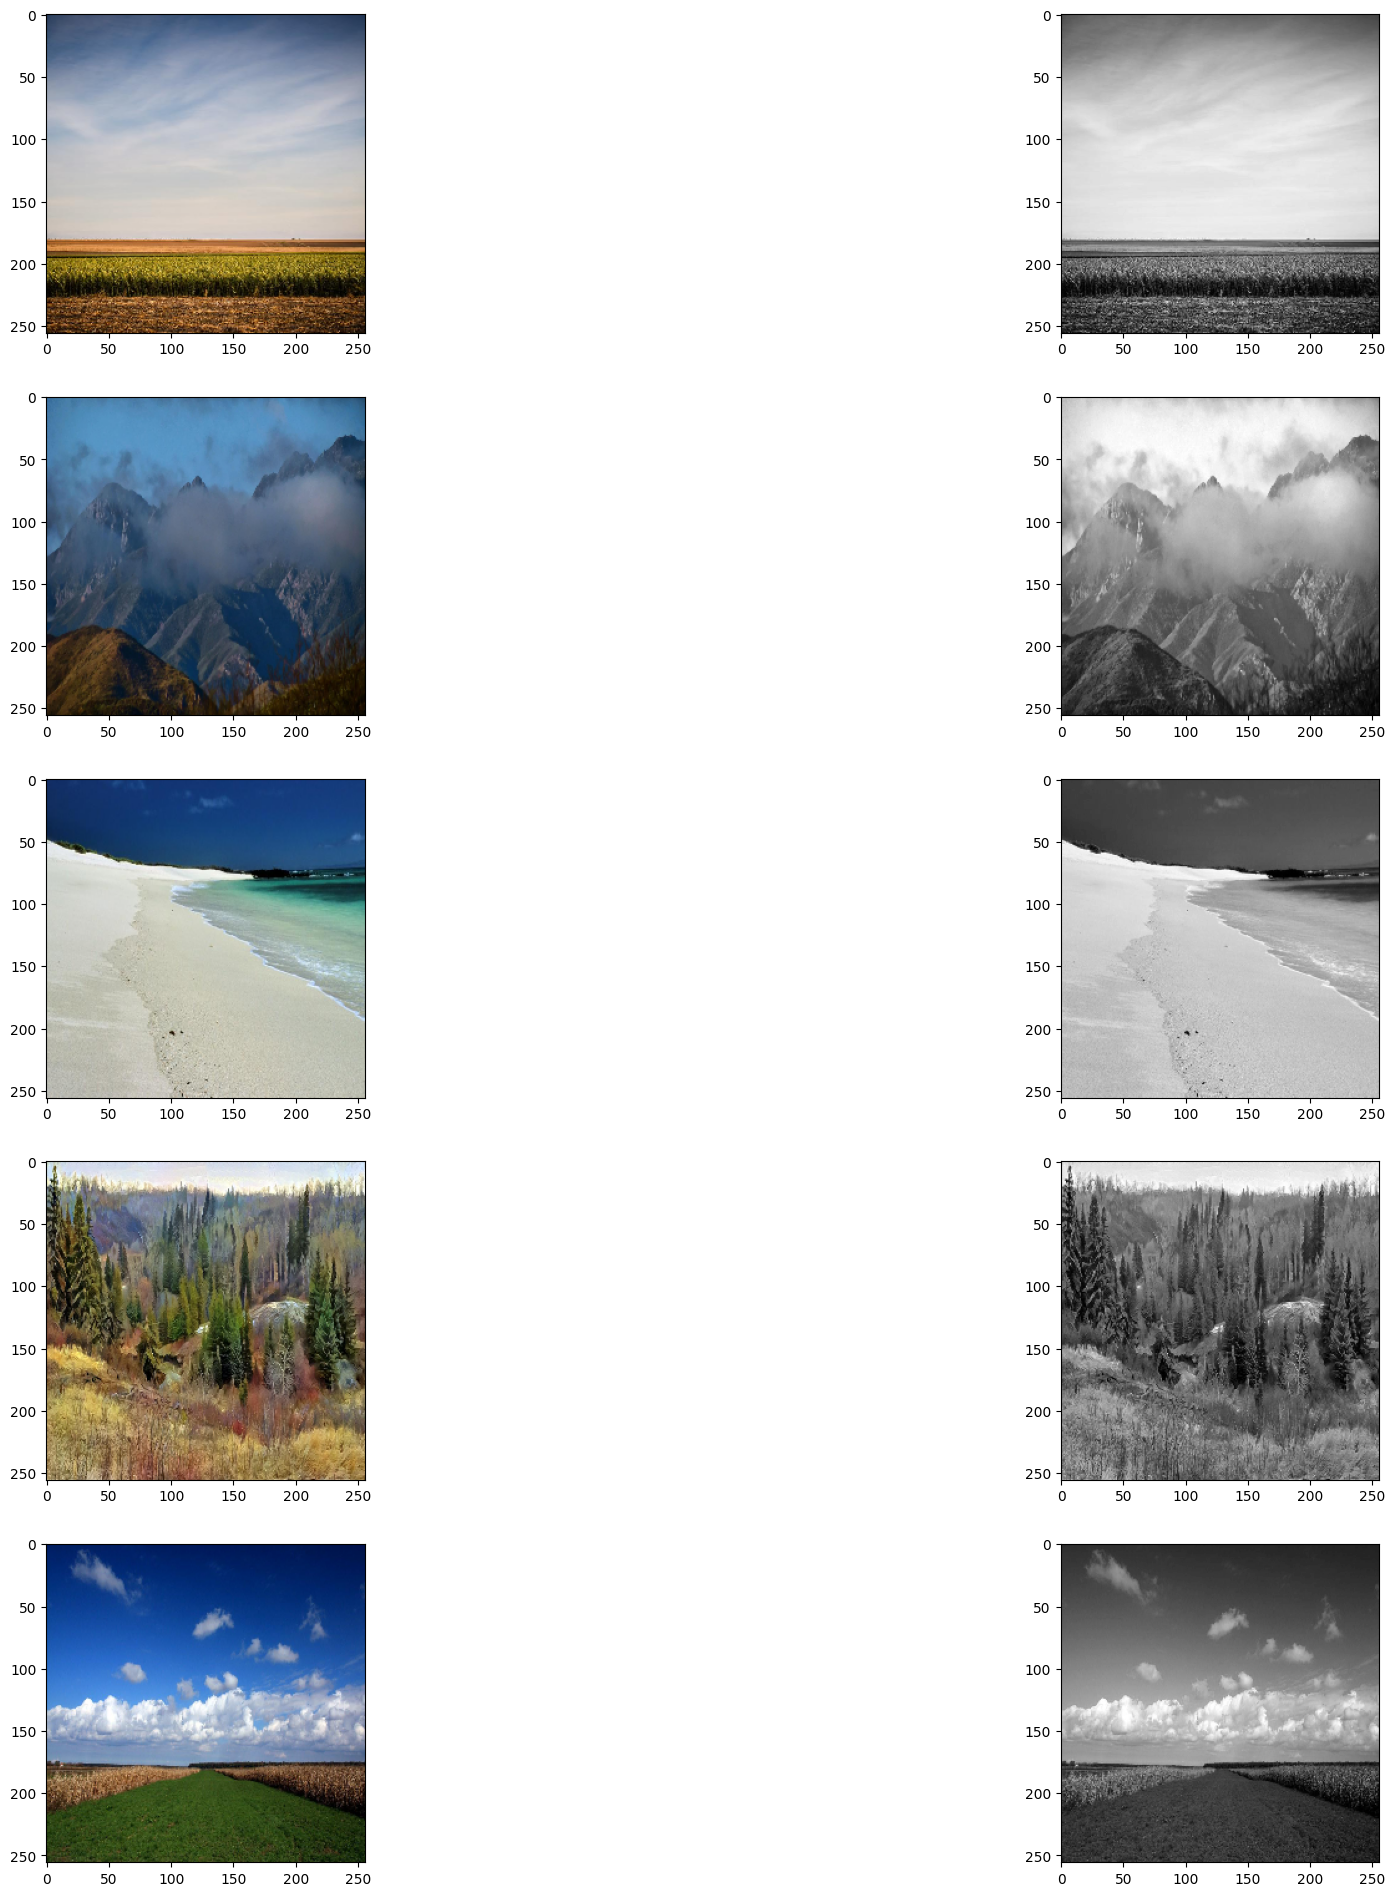

In [31]:
import matplotlib.pyplot as plt
trainset = ColorizationDataset(train=True)
fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = batch['gray_image'][0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(gray,cmap='gray')
plt.show()


# Training Loop With Skip

In [7]:
import torch
from tqdm.notebook import tqdm


trainset = ColorizationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = ColorizationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

net = UNetSkip(in_channels=1, out_channels=3)
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs=5
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs;
          gray_images = data["gray_image"]
          color_images = data["image"]

          # Get the inputs to the GPU
          gray_images = gray_images.cuda()
          color_images = color_images.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(gray_images)
          loss = nn.functional.l1_loss(outputs, color_images)
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
          prog_bar.update(4)


Epoch: 0/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 1/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 2/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 3/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 4/5:   0%|          | 0/3819 [00:00<?, ?img/s]

## Display output examples from the test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


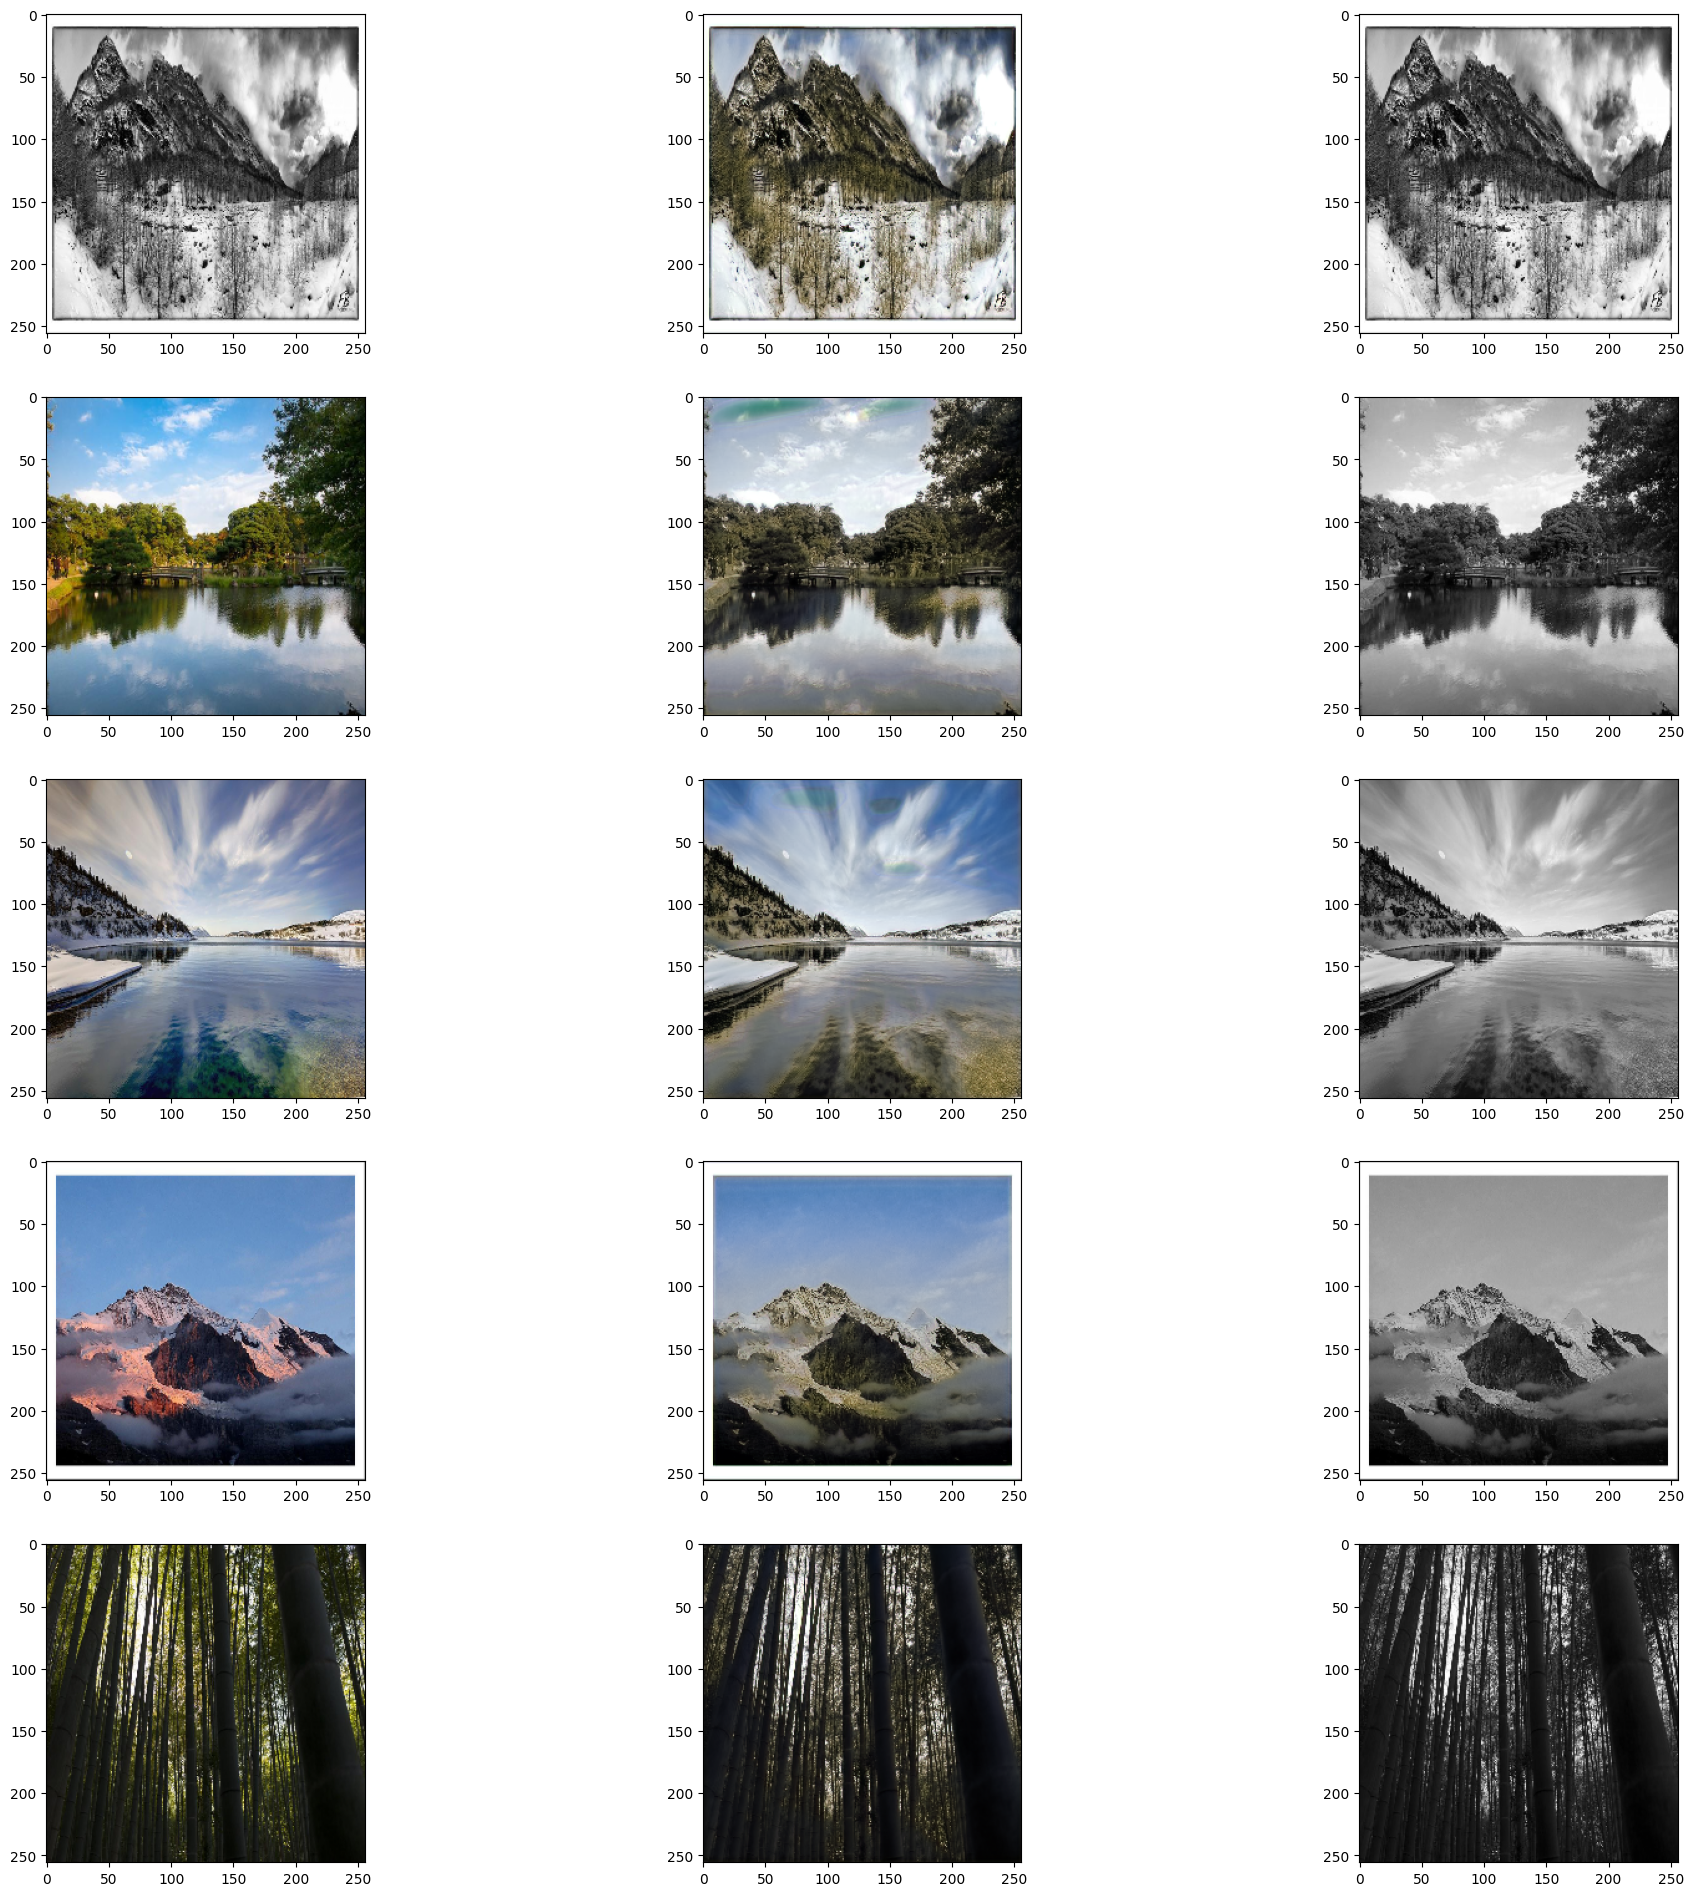

In [10]:
net.eval()
fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[i+80]
  img = batch['image']
  gray = batch['gray_image']
  img_tensor = torch.from_numpy(gray).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy().transpose((1,2,0))
  out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = gray[0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(out_image)
  fig.add_subplot(rows, columns, i*columns+3)
  plt.imshow(gray,cmap='gray')

plt.show()

# Training Loop No Skip

In [20]:
import torch
from tqdm.notebook import tqdm


trainset = ColorizationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = ColorizationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

net = UNet(in_channels=1, out_channels=3)
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs=5
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs;
          gray_images = data["gray_image"]
          color_images = data["image"]

          # Get the inputs to the GPU
          gray_images = gray_images.cuda()
          color_images = color_images.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(gray_images)
          loss = nn.functional.l1_loss(outputs, color_images)
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
          prog_bar.update(4)


Epoch: 0/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 1/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 2/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 3/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 4/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


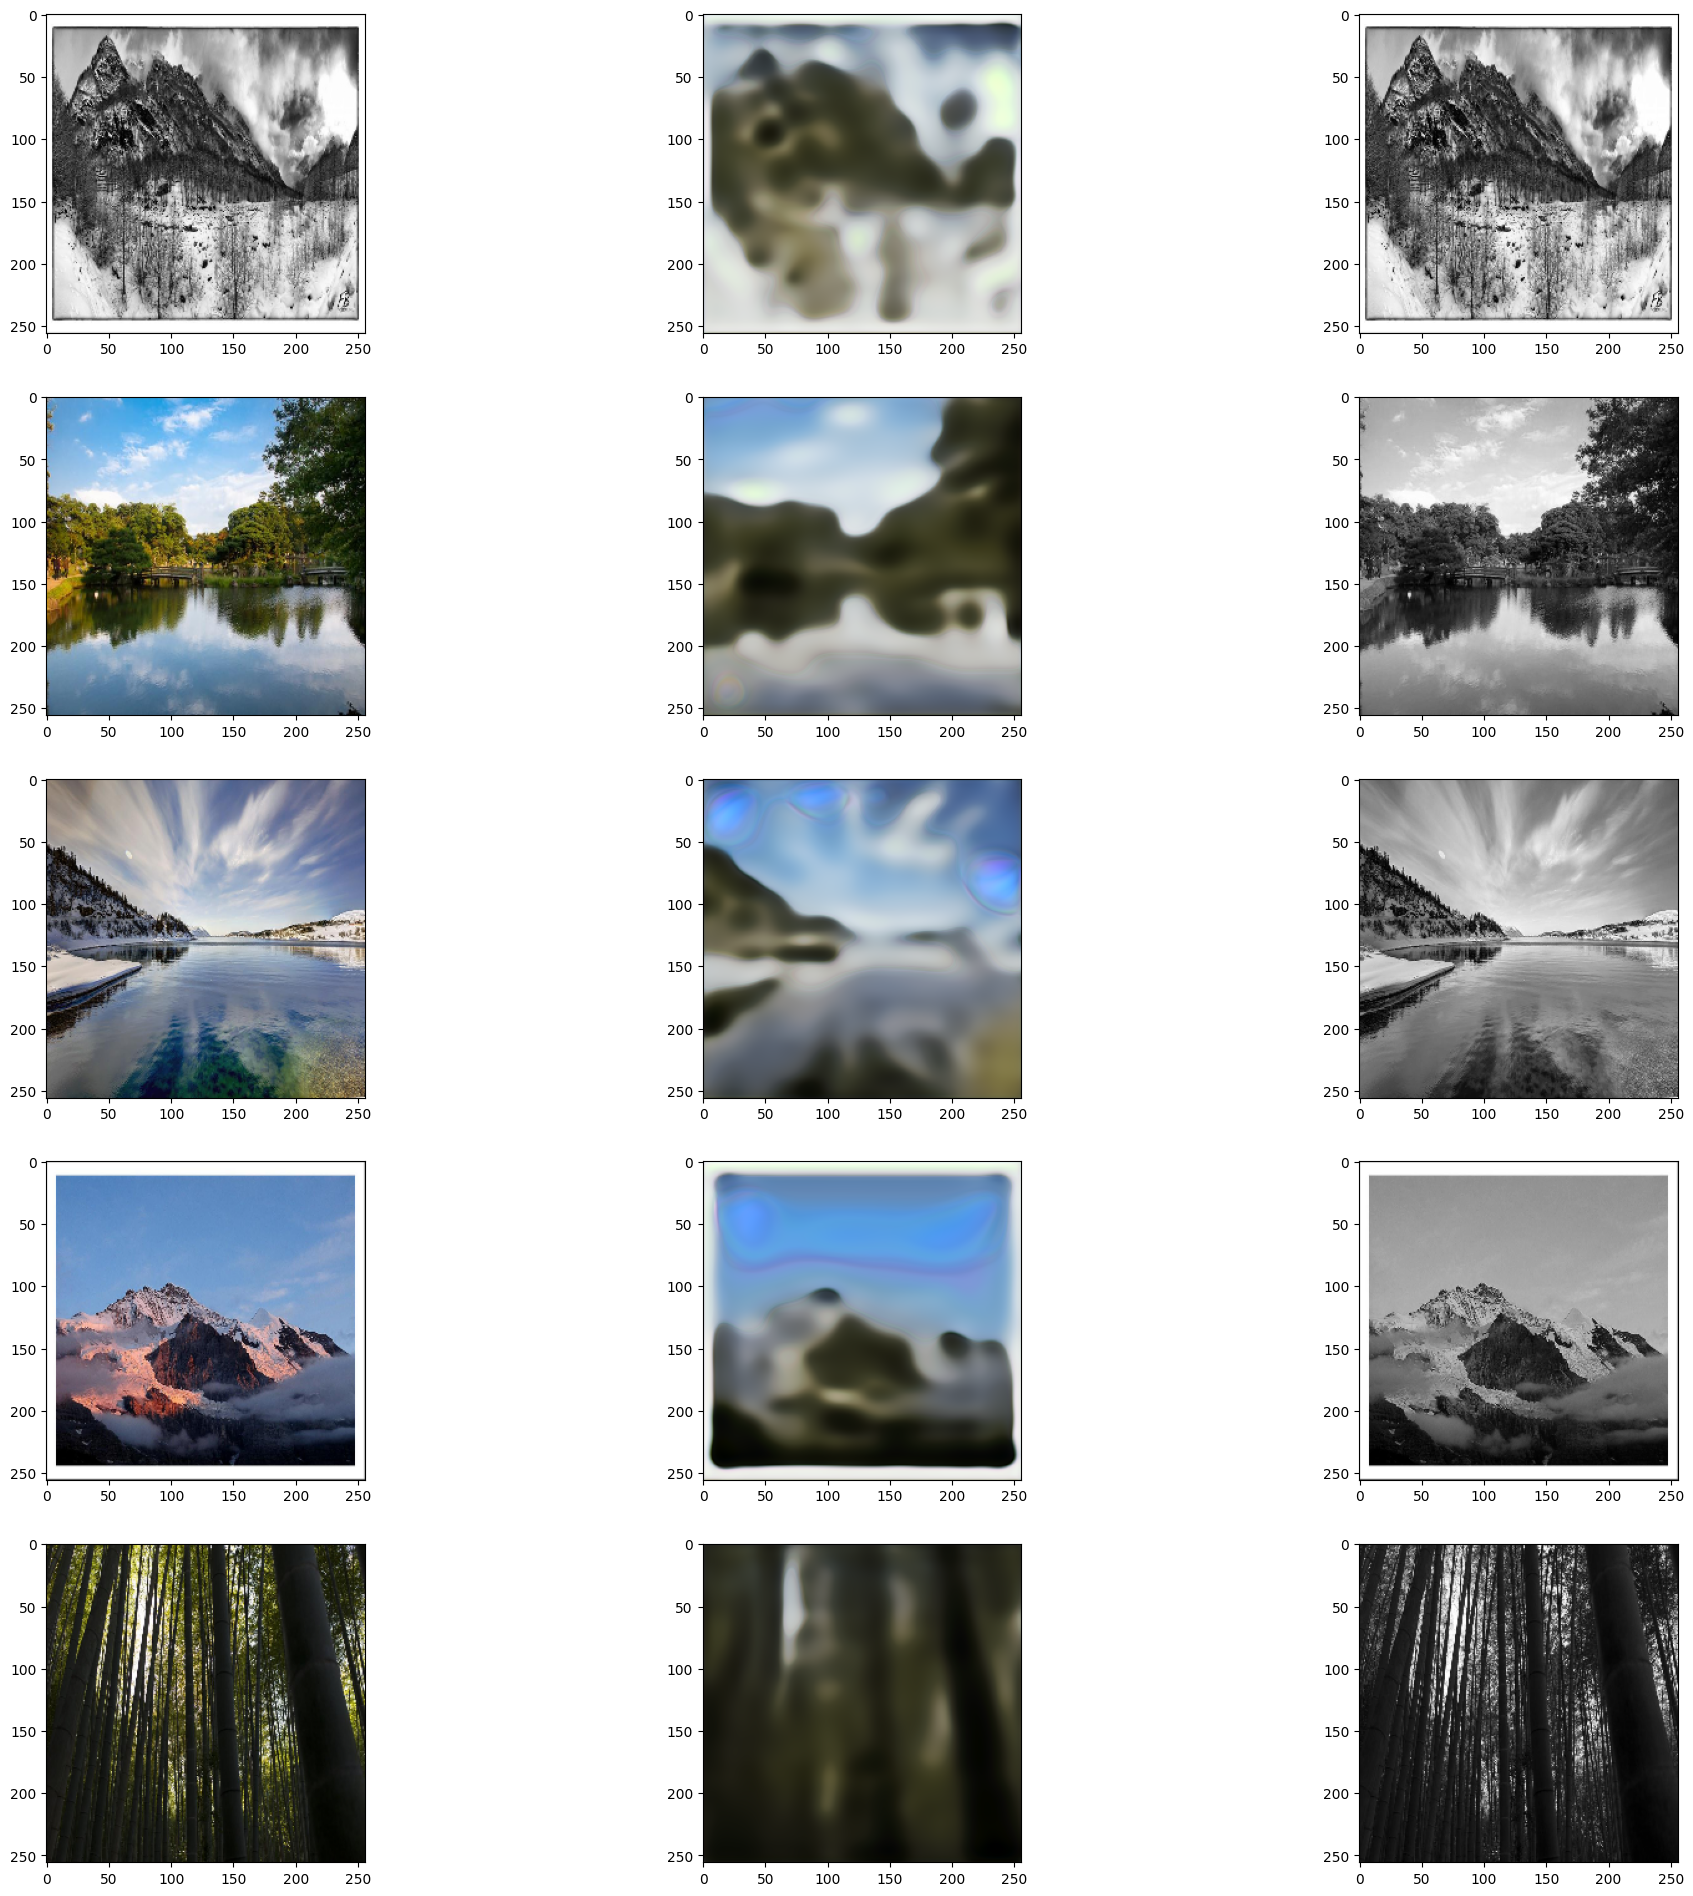

In [21]:
net.eval()
fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[i+80]
  img = batch['image']
  gray = batch['gray_image']
  img_tensor = torch.from_numpy(gray).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy().transpose((1,2,0))
  out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = gray[0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(out_image)
  fig.add_subplot(rows, columns, i*columns+3)
  plt.imshow(gray,cmap='gray')

plt.show()